In [23]:
from ase.db import connect

In [24]:
import numpy as np
import torch
import scipy
import torch.nn as nn
from scipy.spatial import distance_matrix
from torch.utils.data import Dataset
from time import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import glob
# %matplotlib inline
import os
from sklearn import preprocessing
import torch
import requests
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from torch.utils.data import DataLoader
from IPython.display import clear_output
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [25]:
database_path = "test.db"  # Путь к файлу базы данных
database = connect(database_path)  # Загрузка базы данных
row = database.get(1)  # Взятие первого элемента из базы. Нумерация начинается с 1
n_atoms = row.natoms  # Количество атомов в молекуле
numbers = row.numbers  # Атомные числа атомов молекулы
symbols = row.symbols  # Названия атомов молекулы
positions = row.positions  # Координаты атомов. np.array размера n_atoms x 3
energy = row.data.get('energy') # Энергия. float значение энергии

In [26]:
len(database)

32884

In [228]:
n_atoms = []
numbers = []
symbols = []
positions = []
energy = []
for i in range(50000):
    try:
        row = database.get(i)
        n_atoms.append(row.natoms)  # Количество атомов в молекуле
        numbers.append(row.numbers)  # Атомные числа атомов молекулы
        symbols.append(row.symbols)  # Названия атомов молекулы
        positions.append(row.positions)  # Координаты атомов. np.array размера n_atoms x 3
        energy.append(row.data.get('energy'))
    except:
        continue


In [229]:
positions = np.array(positions)
numbers = np.array(numbers)
n_atoms = np.array(n_atoms)
energy = np.array(energy)
symbols = np.array(symbols)

/home/legchenko/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/home/legchenko/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/home/legchenko/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

In [260]:
len(positions)

32884

In [230]:
def pad_pos(x,l = 31):
    pos_padded = []
    for i in x:
        if len(i)<l:
            v = l - len(i)
            p = np.array([[0,0,0]]*v)
            res = np.concatenate([i,p])
            pos_padded.append(res)
        else:
            pos_padded.append(i)
    return np.array(pos_padded)

def pad_symb(x,l = 31):
    padded = []
    for i in x:
        if len(i)<l:
            v = l - len(i)
            p = np.array(['-']*v)
            res = np.concatenate([i,p])
            padded.append(res)
        else:
            padded.append(i)
    return np.array(padded)

def pad_numbers(x,l = 31):
    padded = []
    for i in x:
        if len(i)<l:
            v = l - len(i)
            p = np.array([0]*v)
            res = np.concatenate([i,p])
            padded.append(res)
        else:
            padded.append(i)
    return np.array(padded)

        

In [231]:
padded_pos = pad_pos(positions)

In [232]:
padded_num = pad_numbers(numbers)

In [233]:
padded_symb = pad_symb(symbols)

In [249]:
from collections import Counter
from sklearn.feature_extraction import DictVectorizer

db = connect("train.db")
db_test = connect("test.db")

numbers = []
for row in db.select():
    numbers.append(row.numbers)

numbers_test = []

for row in db_test.select():
    numbers_test.append(row.numbers)

d = DictVectorizer()

padded_num = pad_numbers(numbers)
padded_num_test = pad_numbers(numbers_test)

numbers_onehot = d.fit_transform([Counter(x) for x in padded_num])
numbers_onehot_test = d.transform([Counter(x) for x in padded_num_test])

In [274]:
no = numbers_onehot_test.toarray()

In [257]:
so[0]

array([2., 7., 0., 0., 5., 1., 2., 0.])

In [247]:
!pip install ase
from ase.db import connect

In [234]:
def get_mask(n, l = 31):
    res = []
    for i in n:
        v = l-i
        res.append(np.pad(np.ones([i,i]), [0,v]))
    return np.array(res)

In [235]:
def get_dist(pos):
    res = []
    for i in pos:
        res.append(distance_matrix(i, i, p=2))
    return np.array(res)

In [236]:
masks = get_mask(n_atoms)

In [237]:
dist_mat = get_dist(padded_pos)

In [238]:
masked_dist = dist_mat*masks

In [262]:
dist_mat.shape

(32884, 31, 31)

In [239]:
l_mean = []
for i in dist_mat:
    l_mean.append(i.sum()/((i != 0).sum()))

In [264]:
len(l_mean)

32884

In [240]:
l_max = dist_mat[:,0].max(axis = 1)

In [241]:
l_var = []
for i in dist_mat:
    no = []
    for j in i:
        for k in j:
            if(k!=0):
                no.append(k)
    l_var.append(np.var(np.unique(no)))

In [242]:
l_min = []
for i in dist_mat:
    no = []
    for j in i[0]:
        if(j!=0):
            no.append(j)
    l_min.append(np.min(no))

In [243]:
symb_encode = OneHotEncoder()

In [244]:
symb_encode.fit_transform(np.unique(np.concatenate(padded_symb)).reshape(-1,1)).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [245]:
symb_coded = np.array(symb_encode.transform(padded_symb.reshape(-1,1)).toarray()).reshape(len(padded_symb),31,9)

In [246]:
so = symb_coded[:,:,1:]
so = so.sum(axis = 1)

In [47]:
import torch

In [52]:
regr = torch.load('regr')
scaler = torch.load('scaler')

In [265]:
l_var = np.array(l_var).reshape(-1,1)
l_mean = np.array(l_mean).reshape(-1,1)
l_max = np.array(l_max).reshape(-1,1)
l_min = np.array(l_min).reshape(-1,1)
X_test = np.concatenate([so, l_min, l_max, l_mean,l_var], axis = 1)
X_test = scaler.transform(X_test)

In [54]:
ans = regr.predict(X_test)

In [65]:
df = pd.DataFrame()
df['id'] = np.arange(1,len(ans)+1)
df['energy'] = ans

In [66]:
df.to_csv('ans0.csv', index = False)

In [67]:
emb = torch.load('emb1')

In [69]:
np.concatenate(emb).shape

(40000, 768)

In [275]:
dist_train, dist_test,  symb_train, symb_test, num_train, num_test, energy_train, energy_test, so_train, so_test, min_train, min_test, max_train, max_test, mean_train, mean_test, var_train, var_test, no_train, no_test = train_test_split(masked_dist, symb_coded,padded_num ,energy, so, l_min, l_max, l_mean, l_var, no,test_size=0.1)

ValueError: Found input variables with inconsistent numbers of samples: [32884, 32884, 200232, 32884, 32884, 32884, 32884, 32884, 32884, 32884]

In [52]:
dist_train = dist_train.astype(np.float32)
dist_test = dist_test.astype(np.float32)
symb_train = symb_train.astype(np.float32)
symb_test = symb_test.astype(np.float32)
num_train = num_train.astype(np.float32)
num_test = num_test.astype(np.float32)
energy_train = energy_train.astype(np.float32)
energy_test = energy_test.astype(np.float32)
so_train = so_train.astype(np.float32)
so_test = so_test.astype(np.float32)

In [628]:
batch_size = 8
train_loader = DataLoader(list(zip(dist_train, symb_train,num_train, energy_train, so_train)), 
                     batch_size=batch_size, shuffle=True)

test_loader = DataLoader(list(zip(dist_test, symb_test,num_test, energy_test, so_test)), 
                     batch_size=batch_size, shuffle=True)

In [696]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=25, random_state=0).fit(energy.reshape(-1,1))
kmeans.labels_

array([ 2, 11, 11, ...,  4,  4,  4], dtype=int32)

In [697]:
df = pd.DataFrame()
df['cl'] = kmeans.labels_

In [698]:
df['cl'].value_counts()

0     20434
8     18731
11    14375
18    12394
22    11626
5     11459
10    10999
20    10482
7      8607
24     8518
23     8222
19     8194
15     7935
1      6594
4      6458
2      6297
9      6007
17     4889
13     4584
21     4095
14     3833
6      3137
12     1322
16      602
3       438
Name: cl, dtype: int64

(array([374., 365., 610., 641., 313., 411., 461., 248., 364., 308.]),
 array([-2033.32635831, -2021.28483855, -2009.24331878, -1997.20179902,
        -1985.16027925, -1973.11875948, -1961.07723972, -1949.03571995,
        -1936.99420019, -1924.95268042, -1912.91116065]),
 <BarContainer object of 10 artists>)

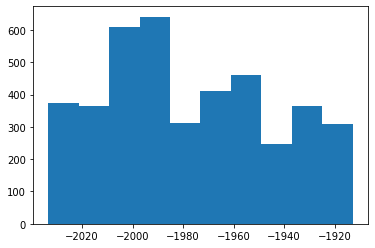

In [709]:
plt.hist(energy[kmeans.labels_ == 21])

In [724]:
!git clone  https://github.com/bond005/snn.git

fatal: destination path 'snn' already exists and is not an empty directory.


In [762]:
energy


array([-1756.70839253, -1297.30795219, -1297.29039335, ...,
       -3713.21114954, -3713.19767423, -3713.19525208])

In [761]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.5 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [757]:
for name, obj in inspect.getmembers(snn):
    if inspect.isclass(obj):
        print(obj)


In [712]:
# Эксперименты с автокодировщиком 

ase_database_example.py*        nohup.out*                      train.db*
grover/                         sample_submission_molhack.csv*  Untitled.ipynb*
grover_large.tar.gz*            smiles_train.rar*               xyz2mol/
linear_regression_baseline.py*  snn/
molhack-2022.zip*               test.db*


In [629]:
e = 64
m = 256
d = 0.1

symb_encoder = nn.Sequential(
          nn.Linear(9, e),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(e,e),
          nn.LeakyReLU()
        )

dist_encoder = nn.Sequential(
          nn.Linear(31, e),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(e, e),
          nn.LeakyReLU()
        )

num_encoder = nn.Sequential(
          nn.Linear(31, e),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(e,e),
          nn.LeakyReLU()
        )

encoder = nn.Sequential(
          nn.Linear(e*3, m),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(m,int(m/2)),
          nn.LeakyReLU(),
          nn.Linear(int(m/2),int(m/4)),
          nn.LeakyReLU()
        )

decoder  = nn.Sequential(
          nn.Linear(int(m/4), int(m/2)),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(int(m/2),m),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(m, e*3),
          nn.LeakyReLU()
        )


num_decoder = nn.Sequential(
          nn.Linear(e*3, e),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(e,31),
          nn.LeakyReLU()
        )

symb_decoder = nn.Sequential(
          nn.Linear(e*3, e),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(e,9),
          #nn.LeakyReLU()
        )

dist_decoder = nn.Sequential(
          nn.Linear(e*3, e),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(e,31),
          nn.LeakyReLU()
        )

cl_head = nn.Sequential(
          nn.Linear(int(m/4)+8, int(m/2)),
          nn.LeakyReLU(),
          nn.Dropout(d),
          nn.Linear(int(m/2),int(m/2)),
          nn.LeakyReLU(),
          nn.Linear(int(m/2),1),
        )

In [630]:
ae = [symb_encoder, dist_encoder, num_encoder, encoder, decoder, num_decoder,dist_decoder, symb_decoder, cl_head]

In [631]:
def train(ae, opt, lr, loss_reg, loss_cl, epochs, data_tr, data_val):
    params = []
    for i in ae:
        params+=list(i.parameters())
    optimizer = opt(params, lr = lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
    hist_loss = []
    accuracy = []
    val_accuracy = []
    hist_val_loss = []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        dist_loss = 0
        num_loss = 0
        symb_loss = 0
        pred_loss = 0
        ac = 0
        for i in ae:
            i.train()  # train mode
        n = 0
        for dist_batch, symb_batch,num_batch, energy_batch, so_batch in data_tr:
            # data to device
            dist = dist_batch.view([dist_batch.shape[0]*dist_batch.shape[1], 31]).to(device)
            symb = symb_batch.view([symb_batch.shape[0]*symb_batch.shape[1], 9]).to(device)
            num = [list(num_batch.numpy())]*31
            num = torch.tensor(np.concatenate(num)).to(device)
            energy = energy_batch.to(device).reshape(energy_batch.shape[0],1)
            so = so_batch.to(device)
            
            # set parameter gradients to zero
            optimizer.zero_grad()

            s_cod = ae[0](symb)
            d_cod = ae[1](dist)
            n_cod = ae[2](num)
            
            #print(s_cod.shape)
            #print(d_cod.shape)
            vec = torch.concat([s_cod, d_cod, n_cod], axis = 1)
            #print(vec.shape)
            cod = ae[3](vec)
            mean = torch.mean(cod.view(dist_batch.shape[0], 31, cod.shape[-1]), axis = 1)
            conc = torch.concat([mean, so], axis = 1)
            pred = ae[8](conc)
            
            decod = ae[4](cod)
            
            n_decod = ae[5](decod)
            d_decod = ae[6](decod)
            s_decod = ae[7](decod)
            
            
            
            # forward
            loss_d = loss_reg(d_decod, dist)
            loss_s = loss_cl(s_decod, symb)
            loss_n = loss_reg(n_decod, num)
            loss_p = loss_reg(pred, energy)
            loss =  loss_d*10 + loss_s + loss_n+loss_p*0.0001 # forward-pass
            
            
            loss.backward()  # backward-pass
            torch.nn.utils.clip_grad_norm(params, 0.001)
            optimizer.step()  # update weights

            dist_loss += loss_d.item() / len(data_tr)
            num_loss += loss_n.item() / len(data_tr)
            symb_loss += loss_s.item() / len(data_tr)
            pred_loss += loss_p.item() / len(data_tr)
        scheduler.step()
        print('loss: %f' % (dist_loss+num_loss+symb_loss+pred_loss))
        hist_loss.append([dist_loss, num_loss, symb_loss, pred_loss])

        # show intermediate results
        for i in ae:
            i.eval()  # testing mode
        dist_loss = 0
        num_loss = 0
        symb_loss = 0
        pred_loss = 0
        for dist_batch, symb_batch,num_batch, energy_batch, so_batch in data_val:
            dist = dist_batch.view([dist_batch.shape[0]*dist_batch.shape[1], 31]).to(device)
            symb = symb_batch.view([symb_batch.shape[0]*symb_batch.shape[1], 9]).to(device)
            num = [list(num_batch.numpy())]*31
            num = torch.tensor(np.concatenate(num)).to(device)
            energy = energy_batch.to(device).reshape(energy_batch.shape[0],1)
            so = so_batch.to(device)
            
            # set parameter gradients to zero
            optimizer.zero_grad()

            s_cod = ae[0](symb)
            d_cod = ae[1](dist)
            n_cod = ae[2](num)
            
            #print(s_cod.shape)
            #print(d_cod.shape)
            vec = torch.concat([s_cod, d_cod, n_cod], axis = 1)
            #print(vec.shape)
            cod = ae[3](vec)
            mean = torch.mean(cod.view(dist_batch.shape[0], 31, cod.shape[-1]), axis = 1)
            conc = torch.concat([mean, so], axis = 1)
            pred = ae[8](conc)
            
            decod = ae[4](cod)
            
            n_decod = ae[5](decod)
            d_decod = ae[6](decod)
            s_decod = ae[7](decod)
            
            
            # forward
            loss_d = loss_reg(d_decod, dist)
            loss_s = loss_cl(s_decod, symb)
            loss_n = loss_reg(n_decod, num)
            pred_loss += loss_p.item() / len(data_tr)
            #loss =  loss_d + loss_s + loss_n # forward-pass

            dist_loss += loss_d.item() / len(data_tr)
            num_loss += loss_n.item() / len(data_tr)
            symb_loss += loss_s.item() / len(data_tr)
            pred_loss += loss_p.item() / len(data_tr)
        print('loss: %f' % (dist_loss+num_loss+symb_loss+pred_loss))
        hist_val_loss.append([dist_loss, num_loss, symb_loss, pred_loss])
        # Visualize tools
        if(epoch%10==0):
            l = np.array(hist_loss)
            vl = np.array(hist_val_loss)
            clear_output(wait=True)
            plt.figure(figsize=[10,20])
            plt.subplot(4, 1, 1)
            plt.plot(l[:,0])
            plt.plot(vl[:,0],linestyle = '--')
            
            plt.subplot(4, 1, 2)
            plt.plot(l[:,1])
            plt.plot(vl[:,1],linestyle = '--')
            
            plt.subplot(4, 1, 3)
            plt.plot(l[:,2])
            plt.plot(vl[:,2],linestyle = '--')
            
            plt.subplot(4, 1, 4)
            plt.plot(l[:,3])
            plt.plot(vl[:,3],linestyle = '--')
            plt.show()

    return hist_loss, hist_val_loss

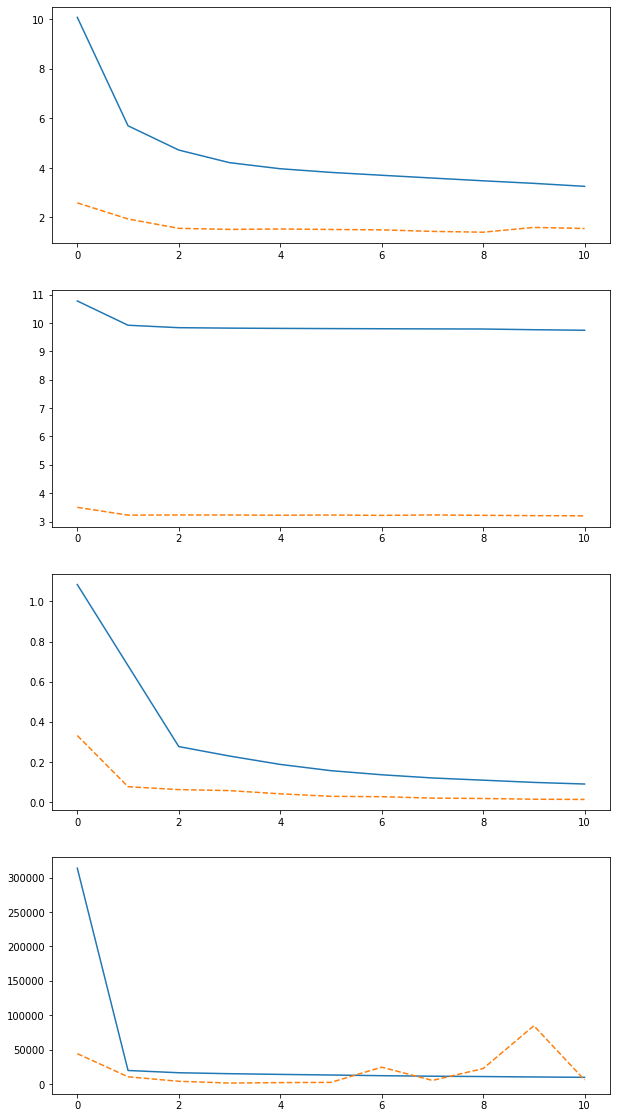

* Epoch 12/20


/home/legchenko/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


loss: 8998.794127
loss: 4796.624829
* Epoch 13/20
loss: 8626.838290
loss: 1747.795126
* Epoch 14/20


KeyboardInterrupt: 

In [632]:
device = 'cuda'
for i in ae:
    i.to(device)

max_epochs = 20
optim = torch.optim.AdamW
loss, val_loss = train(ae, optim, 0.0001, nn.MSELoss(reduce = None), nn.CrossEntropyLoss(reduce=None), max_epochs, train_loader, test_loader)

In [647]:
def feach(ae,loader):
    with torch.no_grad():
        res = []
        en = []
        s = []
        m = []
        for dist_batch, symb_batch,num_batch, energy_batch,so_batch in loader:
                dist = dist_batch.view([dist_batch.shape[0]*dist_batch.shape[1], 31]).to(device)
                symb = symb_batch.view([symb_batch.shape[0]*symb_batch.shape[1], 9]).to(device)
                num = [list(num_batch.numpy())]*31
                num = torch.tensor(np.concatenate(num)).to(device)
                so = so_batch.to(device)
                #energy = energy_batch.to(device)

                # set parameter gradients to zero
                s_cod = ae[0](symb)
                d_cod = ae[1](dist)
                n_cod = ae[2](num)

                #print(s_cod.shape)
                #print(d_cod.shape)
                vec = torch.concat([s_cod, d_cod, n_cod], axis = 1)
                #print(vec.shape)

                cod = ae[3](vec)
                mean = torch.mean(cod.view(dist_batch.shape[0], 31, cod.shape[-1]), axis = 1)
                conc = torch.concat([mean, so], axis = 1)
                
                pred = ae[8](conc).detach().to('cpu').numpy()
                #cod = cod.view([int(dist_batch.shape[0]), 31, 64]).to('cpu').numpy()
                res.append(pred)
                s.append(so_batch)
                m.append(mean.detach().to('cpu').numpy())
                
                en.append(energy_batch)
        return np.concatenate(res), np.concatenate(en), np.concatenate(s), np.concatenate(m)
            

In [652]:
pred, y_train, so_train , fe = feach(ae, train_loader)

In [785]:
X = np.concatenate([fe, so_train], axis = 1)

In [786]:
X.shape

(150174, 72)

In [490]:
X_train = feach_train.reshape(X_train.shape[0],31*32)

In [500]:
X_train = X_train.mean(axis = 1)

In [383]:
# Предикты для финальной линенйой модели

In [373]:
#mean_train = np.array(mean_train).reshape(-1,1)
#max_train = np.array(max_train).reshape(-1,1)
#var_train = np.array(var_train).reshape(-1,1)
#X = np.concatenate([so_train, min_train, max_train, mean_train,var_train], axis = 1)
#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)

var_test = np.array(var_test).reshape(-1,1)
mean_test = np.array(mean_test).reshape(-1,1)
max_test = np.array(max_test).reshape(-1,1)
X_test = np.concatenate([so, l_min, l_max, l_mean,l_var, no], axis = 1)
X_test = scaler.transform(X_test)

In [281]:
scaler.transform(X_test)

array([[ 4.5006103 , -3.13930108, -0.59744505, ..., -0.93198214,
        -0.59744505,  4.5006103 ],
       [-0.48496543, -1.87584037, -0.59744505, ..., -0.93198214,
        -0.59744505, -0.48496543],
       [-0.48496543, -1.87584037, -0.59744505, ..., -0.93198214,
        -0.59744505, -0.48496543],
       ...,
       [-0.48496543, -1.24411001, -0.59744505, ...,  1.84121951,
        -0.59744505, -0.48496543],
       [-0.48496543, -1.24411001, -0.59744505, ...,  1.84121951,
        -0.59744505, -0.48496543],
       [-0.48496543, -1.24411001, -0.59744505, ...,  1.84121951,
        -0.59744505, -0.48496543]])

In [374]:
regr = torch.load('regr')
regr1 = torch.load('regr1')
regr2 = torch.load('regr2')
regr3 = torch.load('regr3')
scaler = torch.load('scaler')
enc = torch.load('enc')
cl = torch.load('cl')

In [375]:
cl_ans = cl.predict(X_test)
cl_prob  = cl.predict_proba(X_test)

df = pd.DataFrame()
df['labels'] = cl_ans
df['prob'] = np.max(cl_prob,axis = 1)
df['id'] = np.arange(len(cl_ans))
df['dat'] = list(X_test)

In [363]:
low = df[df['prob']<0.9993]

In [364]:
low

,labels,prob,id,dat


In [365]:
df = df[~df['id'].isin(low['id'])]

In [376]:
dat1 = df[df['labels'] == 1]
dat2 = df[df['labels'] == 2]
dat3 = df[df['labels'] == 3]

In [377]:
x1 = np.stack(dat1['dat'].values)
x2 = np.stack(dat2['dat'].values)
x3 = np.stack(dat3['dat'].values)
#x = np.stack(low['dat'].values)

ans1 = regr1.predict(x1)
ans2 = regr2.predict(x2)
ans3 = regr3.predict(x3)
#ans = regr.predict(x)

dat1['ans'] = ans1
dat2['ans'] = ans2
dat3['ans'] = ans3
#low['ans'] = ans

/home/legchenko/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/legchenko/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/home/legchenko/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [378]:
res = pd.concat([dat1, dat2,dat3])

In [379]:
res = res.sort_values(by = 'id')

In [380]:
b = pd.DataFrame()
a = res['ans'].values
b['id'] = np.arange(1,len(a)+1)
b['energy'] = a

In [381]:
b.to_csv('ans8.csv',index = False)

In [382]:
b

,id,energy
0,1,-5622.198644
1,2,-924.341189
2,3,-924.337820
3,4,-924.329543
4,5,-1524.790423
...,...,...
32879,32880,-1422.482426
32880,32881,-1422.479015
32881,32882,-1422.484397
32882,32883,-1422.486147


In [642]:
pred = pred.reshape(pred.shape[0])

In [576]:
energy.shape

(200232,)

In [383]:
feach_test = feach(ae, test_loader)

In [139]:
ridge_regr = BayesianRidge()

In [140]:
ridge_regr.fit(X,energy_train)

BayesianRidge()

In [141]:
pred = ridge_regr.predict(X)

In [137]:
X = X[energy_train > -6500]

In [145]:
(energy < -7000).sum()

1

In [138]:
#X = X[energy_train > -6500]
energy_train = energy_train[energy_train > -6500]

In [142]:
print('MSE: %.4f' % mean_squared_error(energy_train, pred))
print('MAE: %.4f' % mean_absolute_error(energy_train, pred))
print('R^2: %.4f' % r2_score(energy_train, pred))

MSE: 58.4074
MAE: 0.0902
R^2: 0.9999


In [143]:
pred = ridge_regr.predict(X_test)

In [144]:
print('MSE: %.4f' % mean_squared_error(energy_test, pred))
print('MAE: %.4f' % mean_absolute_error(energy_test, pred))
print('R^2: %.4f' % r2_score(energy_test, pred))

MSE: 0.0087
MAE: 0.0652
R^2: 1.0000


In [127]:
pred

array([-3272.53343232, -4027.23598453, -3255.58654792, ...,
       -3204.71349847, -3230.14221012, -3142.19565703])

In [72]:
snn = SNNRegressor(minibatch_size = 2056, n_layers = 5,ensemble_size = 4, verbose = True)

In [798]:
snn.__sizeof__()

32

In [789]:
embs = torch.load('embs')

In [74]:
X = np.concatenate(emb)

In [75]:
snn.fit(X, energy[:40000] )

ValueError: Found input variables with inconsistent numbers of samples: [40000, 32884]

In [799]:
import copy
import gc
import random
import re
from typing import List, Tuple, Union
import uuid

import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted
import tensorflow as tf
import tensorflow_addons as tfa


def build_preprocessor(X: np.ndarray, seed: int) -> Pipeline:
    preprocessor = Pipeline(steps=[
        (
            'selector',
            VarianceThreshold()
        ),
        (
            'standard_scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=seed)
        )
    ])
    preprocessor.fit(X.astype(np.float64))
    return preprocessor


def build_neural_network(input_size: int, layer_size: int, n_classes: int,
                         n_layers: int, dropout_rate: float, scale_coeff: float,
                         nn_name: str) -> tf.keras.Model:
    feature_vector = tf.keras.layers.Input(
        shape=(input_size,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    hidden_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_dropout1'
    )(feature_vector)
    for layer_idx in range(1, (2 * n_layers) // 3 + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    cls_layer = tf.keras.layers.Dense(
        units=n_classes,
        activation=None,
        use_bias=True,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_classification'
    )(hidden_layer)
    for layer_idx in range((2 * n_layers) // 3 + 1, n_layers + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=None,
        use_bias=True,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_regression'
    )(hidden_layer)
    neural_network = tf.keras.Model(
        inputs=feature_vector,
        outputs=[output_layer, cls_layer],
        name=nn_name
    )
    radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    losses = {
        f'{nn_name}_regression': tf.keras.losses.MeanAbsoluteError(),
        f'{nn_name}_classification': tf.keras.losses.CategoricalCrossentropy(
            label_smoothing=0.01,
            from_logits=True
        )
    }
    loss_weights = {
        f'{nn_name}_regression': 1.0,
        f'{nn_name}_classification': 0.5
    }
    metrics = {
        f'{nn_name}_regression': [
            tf.keras.metrics.MeanAbsoluteError()
        ]
    }
    neural_network.compile(
        optimizer=ranger,
        loss=losses,
        loss_weights=loss_weights,
        metrics=metrics
    )
    return neural_network


def predict_by_ensemble(input_data: np.ndarray,
                        ensemble: List[tf.keras.Model],
                        postprocessing: StandardScaler,
                        minibatch: int) -> np.ndarray:
    num_samples = input_data.shape[0]
    ensemble_size = len(ensemble)
    predictions_of_ensemble = np.empty((ensemble_size, num_samples),
                                       dtype=np.float64)
    for model_idx, cur_model in enumerate(ensemble):
        y_mean = cur_model.predict(input_data, batch_size=minibatch)[0]
        predictions_of_ensemble[model_idx, :] = y_mean.flatten()
    y = np.mean(predictions_of_ensemble, axis=0)
    y = postprocessing.inverse_transform(y.reshape((y.shape[0], 1))).flatten()
    return y


def discretize_targets(targets: np.ndarray) -> np.ndarray:
    set_of_target_values = set()
    for cur in targets:
        set_of_target_values.add(int(round(100.0 * cur)))
    n_classes = max(3, len(set_of_target_values) // 20)
    discretized = KBinsDiscretizer(
        n_bins=n_classes,
        encode='ordinal',
        strategy='kmeans'
    ).fit_transform(
        targets.reshape((targets.shape[0], 1))
    ).reshape((targets.shape[0],)).astype(np.int32)
    discretized = discretized.astype(np.int32)
    return discretized


class SNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, ensemble_size: int = 20,
                 hidden_layer_size: int = 64, n_layers: int = 18,
                 dropout_rate: float = 3e-4,
                 max_epochs: int = 1000, patience: int = 15,
                 minibatch_size: int = 4096, validation_fraction: float = 0.1,
                 verbose: bool = False, clear_session: bool = True,
                 random_seed: Union[int, None] = None):
        super(SNNRegressor, self).__init__()
        self.ensemble_size = ensemble_size
        self.hidden_layer_size = hidden_layer_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.max_epochs = max_epochs
        self.patience = patience
        self.minibatch_size = minibatch_size
        self.verbose = verbose
        self.validation_fraction = validation_fraction
        self.clear_session = clear_session
        self.random_seed = random_seed

    def fit(self, X, y, **kwargs):
        self.check_params(
            ensemble_size=self.ensemble_size,
            hidden_layer_size=self.hidden_layer_size,
            n_layers=self.n_layers,
            minibatch_size=self.minibatch_size,
            dropout_rate=self.dropout_rate,
            max_epochs=self.max_epochs,
            patience=self.patience,
            validation_fraction=self.validation_fraction,
            verbose=self.verbose,
            clear_session=self.clear_session
        )
        X_, y_ = check_X_y(X, y,
                           force_all_finite='allow-nan',
                           ensure_min_samples=max(self.ensemble_size * 3, 100),
                           multi_output=False, y_numeric=True,
                           estimator='SNNRegressor')
        if 'feature_names' in kwargs:
            feature_names = kwargs['feature_names']
            if (not isinstance(feature_names, list)) and \
                    (not isinstance(feature_names, tuple)):
                err_msg = f'`{feature_names}` is wrong! ' \
                          f'Expected `{type([1, 2])}`, ' \
                          f'got `{type(kwargs["feature_names"])}`.'
                raise ValueError(err_msg)
        else:
            max_number_width = len(str(X_.shape[1]))
            feature_names = ['x{0:>0{1}}'.format(col_idx, max_number_width)
                             for col_idx in range(X_.shape[1])]
        if hasattr(self, 'deep_ensemble_'):
            del self.deep_ensemble_
        if hasattr(self, 'names_of_deep_ensemble_'):
            del self.names_of_deep_ensemble_
        if hasattr(self, 'preprocessor_'):
            del self.preprocessor_
        if hasattr(self, 'postprocessor_'):
            del self.postprocessor_
        if hasattr(self, 'random_gen_'):
            del self.random_gen_
        gc.collect()
        if self.clear_session:
            tf.keras.backend.clear_session()
        self.random_gen_ = np.random.default_rng(
            seed=(self.random_seed if hasattr(self, 'random_seed') else None)
        )
        self.preprocessor_ = build_preprocessor(
            X_, seed=self.random_gen_.integers(0, 2147483647)
        )
        if self.verbose:
            print('')
        self.postprocessor_ = StandardScaler(with_mean=True, with_std=True)
        self.postprocessor_.fit(y_.reshape((y_.shape[0], 1)))
        X_ = self.preprocessor_.transform(
            X_.astype(np.float64)
        ).astype(np.float32)
        y_ = self.postprocessor_.transform(
            y_.reshape((y_.shape[0], 1))
        ).reshape((y_.shape[0],))
        all_indices = np.array(list(range(X_.shape[0])), dtype=np.int32)
        self.random_gen_.shuffle(all_indices)
        X_ = X_[all_indices]
        y_ = y_[all_indices]
        del all_indices
        gc.collect()
        y_class_ = discretize_targets(y_)
        self.n_classes_ = int(np.max(y_class_) + 1)
        y_class__ = np.zeros((y_class_.shape[0], self.n_classes_),
                             dtype=np.float32)
        for sample_idx, class_idx in enumerate(y_class_):
            y_class__[sample_idx, class_idx] = 1.0
        if self.verbose:
            class_freq = np.zeros((self.n_classes_,), dtype=np.int32)
            for class_idx in y_class_:
                class_freq[class_idx] += 1
            max_num_width = max(map(lambda it: len(str(it)), class_freq))
            for class_idx, freq in enumerate(class_freq):
                print('Class {0:>02}: {1:>{2}} samples'.format(class_idx, freq,
                                                               max_num_width))
            print('')
        splitting = []
        for _ in range(self.ensemble_size):
            instant_splitting = list(StratifiedKFold(
                n_splits=int(round(1.0 / self.validation_fraction)),
                shuffle=True,
                random_state=self.random_gen_.integers(0, 2147483647)
            ).split(X_, y_class_))
            splitting.append(instant_splitting[0])
            del instant_splitting
        self.feature_vector_size_ = X_.shape[1]
        self.deep_ensemble_ = []
        self.names_of_deep_ensemble_ = []
        for alg_id in range(self.ensemble_size):
            model_uuid = str(uuid.uuid1()).split('-')[0]
            model_name = f'snn_regressor_{alg_id + 1}_{model_uuid}'
            regression_output_name = f'{model_name}_regression'
            self.names_of_deep_ensemble_.append(model_name)
            train_index, test_index = splitting[alg_id]
            steps_per_epoch = len(train_index) // self.minibatch_size
            train_dataset = tf.data.Dataset.from_tensor_slices(
                (
                    X_[train_index],
                    (
                        y_[train_index].flatten(),
                        y_class__[train_index]
                    )
                )
            ).repeat().shuffle(len(train_index)).batch(self.minibatch_size)
            val_dataset = tf.data.Dataset.from_tensor_slices(
                (
                    X_[test_index],
                    (
                        y_[test_index].flatten(),
                        y_class__[test_index]
                    )
                )
            ).batch(self.minibatch_size)
            new_model = build_neural_network(
                input_size=self.feature_vector_size_,
                layer_size=self.hidden_layer_size,
                n_classes=self.n_classes_,
                n_layers=self.n_layers,
                dropout_rate=self.dropout_rate,
                scale_coeff=self.postprocessor_.scale_[0],
                nn_name=model_name
            )
            if self.verbose:
                print('====================')
                print(f'NEURAL NETWORK {alg_id + 1}')
                print('====================')
                print('')
                new_model.summary()
                print('')
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor=f'val_{regression_output_name}_mean_absolute_error',
                    restore_best_weights=True, mode='min',
                    patience=self.patience, verbose=self.verbose
                )
            ]
            new_model.fit(
                train_dataset, epochs=self.max_epochs,
                steps_per_epoch=steps_per_epoch,
                callbacks=callbacks, validation_data=val_dataset,
                verbose=(2 if self.verbose else 0)
            )
            del callbacks, train_dataset, val_dataset, train_index, test_index
            self.deep_ensemble_.append(new_model)
            del new_model
            gc.collect()
        return self

    def predict(self, X):
        check_is_fitted(self, ['deep_ensemble_', 'names_of_deep_ensemble_',
                               'preprocessor_', 'postprocessor_',
                               'random_gen_', 'feature_vector_size_',
                               'n_classes_'])
        X_ = check_array(X, force_all_finite='allow-nan',
                         estimator='SNNRegressor')
        X_ = self.preprocessor_.transform(
            X_.astype(np.float64)
        ).astype(np.float32)
        y = predict_by_ensemble(
            input_data=X_,
            postprocessing=self.postprocessor_,
            ensemble=self.deep_ensemble_,
            minibatch=self.minibatch_size
        )
        return y

    def fit_predict(self, X, y, **kwargs):
        return self.fit(X, y).predict(X)

    def get_params(self, deep=True) -> dict:
        return {
            'ensemble_size': self.ensemble_size,
            'hidden_layer_size': self.hidden_layer_size,
            'n_layers': self.n_layers,
            'dropout_rate': self.dropout_rate,
            'max_epochs': self.max_epochs,
            'patience': self.patience,
            'minibatch_size': self.minibatch_size,
            'verbose': self.verbose,
            'validation_fraction': self.validation_fraction,
            'clear_session': self.clear_session,
            'random_seed': (self.random_seed if hasattr(self, 'random_seed')
                            else None)
        }

    def set_params(self, **params):
        for parameter, value in params.items():
            self.__setattr__(parameter, value)
        return self

    def _copy_deep_ensemble(self) -> List[tf.keras.Model]:
        new_deep_ensemble = []
        re_for_hidden_layer = re.compile(r'_dense\d+$')
        for alg_id in range(self.ensemble_size):
            model_uuid = str(uuid.uuid1()).split('-')[0]
            model_name = f'snn_regressor_{alg_id + 1}_{model_uuid}'
            new_model = build_neural_network(
                input_size=self.feature_vector_size_,
                layer_size=self.hidden_layer_size,
                n_classes=self.n_classes_,
                n_layers=self.n_layers,
                dropout_rate=self.dropout_rate,
                scale_coeff=self.postprocessor_.scale_[0],
                nn_name=model_name
            )
            new_model.build(input_shape=(None, self.feature_vector_size_))
            old_model = self.deep_ensemble_[alg_id]
            n_copied = 0
            for old_layer, new_layer in zip(old_model.layers, new_model.layers):
                if old_layer.name.endswith('_classification'):
                    copy_weight = True
                elif old_layer.name.endswith('_regression'):
                    copy_weight = True
                else:
                    if re_for_hidden_layer.search(old_layer.name) is None:
                        copy_weight = False
                    else:
                        copy_weight = True
                if copy_weight:
                    n_copied += 1
                    new_layer.set_weights(old_layer.get_weights())
            if n_copied < 1:
                err_msg = f'The neural network {alg_id + 1} cannot be copied!'
                raise ValueError(err_msg)
            new_deep_ensemble.append(new_model)
        return new_deep_ensemble

    def __copy__(self):
        cls = self.__class__
        result = cls.__new__(cls)
        result.set_params(
            ensemble_size=self.ensemble_size,
            hidden_layer_size=self.hidden_layer_size,
            n_layers=self.n_layers,
            dropout_rate=self.dropout_rate,
            max_epochs=self.max_epochs,
            patience=self.patience,
            minibatch_size=self.minibatch_size,
            verbose=self.verbose,
            validation_fraction=self.validation_fraction,
            clear_session=self.clear_session,
            random_seed=self.random_seed
        )
        try:
            check_is_fitted(self, ['deep_ensemble_', 'names_of_deep_ensemble_',
                                   'preprocessor_', 'postprocessor_',
                                   'random_gen_', 'feature_vector_size_',
                                   'n_classes_'])
            is_fitted = True
        except:
            is_fitted = False
        if is_fitted:
            result.deep_ensemble_ = self.deep_ensemble_
            result.names_of_deep_ensemble_ = self.names_of_deep_ensemble_
            result.preprocessor_ = self.preprocessor_
            result.postprocessor_ = self.postprocessor_
            result.random_gen_ = self.random_gen_
            result.feature_vector_size_ = self.feature_vector_size_
            result.n_classes_ = self.n_classes_
        return result

    def __deepcopy__(self, memodict={}):
        cls = self.__class__
        result = cls.__new__(cls)
        memodict[id(self)] = result
        result.set_params(
            ensemble_size=self.ensemble_size,
            hidden_layer_size=self.hidden_layer_size,
            n_layers=self.n_layers,
            dropout_rate=self.dropout_rate,
            max_epochs=self.max_epochs,
            patience=self.patience,
            minibatch_size=self.minibatch_size,
            verbose=self.verbose,
            validation_fraction=self.validation_fraction,
            clear_session=self.clear_session,
            random_seed=self.random_seed
        )
        try:
            check_is_fitted(self, ['deep_ensemble_', 'names_of_deep_ensemble_',
                                   'preprocessor_', 'postprocessor_',
                                   'random_gen_', 'feature_vector_size_',
                                   'n_classes_'])
            is_fitted = True
        except:
            is_fitted = False
        if is_fitted:
            result.feature_vector_size_ = self.feature_vector_size_
            result.n_classes_ = self.n_classes_
            result.names_of_deep_ensemble_ = copy.deepcopy(
                self.names_of_deep_ensemble_,
                memo=memodict
            )
            result.preprocessor_ = copy.deepcopy(self.preprocessor_,
                                                 memo=memodict)
            result.postprocessor_ = copy.deepcopy(self.postprocessor_,
                                                  memo=memodict)
            if self.random_gen_ is None:
                result.random_gen_ = None
            else:
                result.random_gen_ = copy.deepcopy(self.random_gen_,
                                                   memo=memodict)
            result.deep_ensemble_ = self._copy_deep_ensemble()
        return result

    def __getstate__(self):
        params = self.get_params(True)
        try:
            check_is_fitted(self, ['deep_ensemble_', 'names_of_deep_ensemble_',
                                   'preprocessor_', 'postprocessor_',
                                   'random_gen_', 'feature_vector_size_',
                                   'n_classes_'])
            is_fitted = True
        except:
            is_fitted = False
        if is_fitted:
            params['names_of_deep_ensemble_'] = copy.deepcopy(
                self.names_of_deep_ensemble_
            )
            params['feature_vector_size_'] = self.feature_vector_size_
            params['n_classes_'] = self.n_classes_
            params['preprocessor_'] = copy.deepcopy(self.preprocessor_)
            params['postprocessor_'] = copy.deepcopy(self.postprocessor_)
            if self.random_gen_ is None:
                params['random_gen_'] = None
            else:
                params['random_gen_'] = copy.deepcopy(self.random_gen_)
            params['deep_ensemble_'] = []
            for alg_id in range(self.ensemble_size):
                params['deep_ensemble_'].append(
                    self.deep_ensemble_[alg_id].get_weights()
                )
        return params

    def __setstate__(self, state: dict):
        if not isinstance(state, dict):
            err_msg = f'The `state` is wrong! Expected `{type({"a": 1})}`, ' \
                      f'got `{type(state)}`.'
            raise ValueError(err_msg)
        self.check_params(**state)
        is_fitted = ('deep_ensemble_' in state)
        if is_fitted:
            if 'names_of_deep_ensemble_' not in state:
                err_msg = 'The `names_of_deep_ensemble_` is not found ' \
                          'in the `state`!'
                raise ValueError(err_msg)
            if 'feature_vector_size_' not in state:
                err_msg = 'The `feature_vector_size_` is not found ' \
                          'in the `state`!'
                raise ValueError(err_msg)
            if 'preprocessor_' not in state:
                err_msg = 'The `preprocessor_` is not found in the `state`!'
                raise ValueError(err_msg)
            if 'postprocessor_' not in state:
                err_msg = 'The `postprocessor_` is not found in the `state`!'
                raise ValueError(err_msg)
        self.set_params(**state)
        if hasattr(self, 'deep_ensemble_'):
            del self.deep_ensemble_
        if hasattr(self, 'names_of_deep_ensemble_'):
            del self.names_of_deep_ensemble_
        if hasattr(self, 'preprocessor_'):
            del self.preprocessor_
        if hasattr(self, 'postprocessor_'):
            del self.postprocessor_
        if hasattr(self, 'random_gen_'):
            del self.random_gen_
        gc.collect()
        if self.clear_session:
            tf.keras.backend.clear_session()
        if is_fitted:
            self.feature_vector_size_ = state['feature_vector_size_']
            self.n_classes_ = state['n_classes_']
            self.names_of_deep_ensemble_ = copy.deepcopy(
                state['names_of_deep_ensemble_']
            )
            self.preprocessor_ = copy.deepcopy(state['preprocessor_'])
            self.postprocessor_ = copy.deepcopy(state['postprocessor_'])
            if 'random_gen_' in state:
                self.random_gen_ = copy.deepcopy(state['random_gen_'])
            else:
                self.random_gen_ = np.random.default_rng(
                    seed=(self.random_seed if hasattr(self, 'random_seed')
                          else None)
                )
            self.deep_ensemble_ = []
            for alg_id in range(self.ensemble_size):
                model_name = self.names_of_deep_ensemble_[alg_id]
                new_model = build_neural_network(
                    input_size=self.feature_vector_size_,
                    layer_size=self.hidden_layer_size,
                    n_classes=self.n_classes_,
                    n_layers=self.n_layers,
                    dropout_rate=self.dropout_rate,
                    scale_coeff=self.postprocessor_.scale_[0],
                    nn_name=model_name
                )
                new_model.build(input_shape=(None, self.feature_vector_size_))
                new_model.set_weights(state['deep_ensemble_'][alg_id])
                self.deep_ensemble_.append(new_model)
        return self

    @staticmethod
    def check_integer_param(param_name: str, **kwargs):
        if param_name not in kwargs:
            raise ValueError(f'`{param_name}` is not specified!')
        if (not isinstance(kwargs[param_name], int)) and \
                (not isinstance(kwargs[param_name], np.int64)) and \
                (not isinstance(kwargs[param_name], np.uint64)) and \
                (not isinstance(kwargs[param_name], np.int16)) and \
                (not isinstance(kwargs[param_name], np.uint16)) and \
                (not isinstance(kwargs[param_name], np.int8)) and \
                (not isinstance(kwargs[param_name], np.uint8)) and \
                (not isinstance(kwargs[param_name], np.int32)) and \
                (not isinstance(kwargs[param_name], np.uint32)):
            err_msg = f'`{param_name}` is wrong! Expected `{type(3)}`, ' \
                      f'got `{type(kwargs[param_name])}`.'
            raise ValueError(err_msg)
        if kwargs[param_name] < 1:
            err_msg = f'`{param_name}` is wrong! Expected a positive ' \
                      f'integer value, but {kwargs[param_name]} is ' \
                      f'not positive.'
            raise ValueError(err_msg)

    @staticmethod
    def check_boolean_param(param_name: str, **kwargs):
        if param_name not in kwargs:
            raise ValueError(f'`{param_name}` is not specified!')
        if (not isinstance(kwargs[param_name], int)) and \
                (not isinstance(kwargs[param_name], bool)) and \
                (not isinstance(kwargs[param_name], np.bool)) and \
                (not isinstance(kwargs[param_name], np.int64)) and \
                (not isinstance(kwargs[param_name], np.uint64)) and \
                (not isinstance(kwargs[param_name], np.int16)) and \
                (not isinstance(kwargs[param_name], np.uint16)) and \
                (not isinstance(kwargs[param_name], np.int8)) and \
                (not isinstance(kwargs[param_name], np.uint8)) and \
                (not isinstance(kwargs[param_name], np.int32)) and \
                (not isinstance(kwargs[param_name], np.uint32)):
            err_msg = f'`{param_name}` is wrong! Expected `{type(True)}`, ' \
                      f'got `{type(kwargs[param_name])}`.'
            raise ValueError(err_msg)

    @staticmethod
    def check_float_param(param_name: str, **kwargs):
        if param_name not in kwargs:
            raise ValueError(f'`{param_name}` is not specified!')
        if (not isinstance(kwargs[param_name], float)) and \
                (not isinstance(kwargs[param_name], np.float)) and \
                (not isinstance(kwargs[param_name], np.float16)) and \
                (not isinstance(kwargs[param_name], np.float8)) and \
                (not isinstance(kwargs[param_name], np.float32)):
            err_msg = f'`{param_name}` is wrong! Expected `{type(2.3)}`, ' \
                      f'got `{type(kwargs[param_name])}`.'
            raise ValueError(err_msg)

    @staticmethod
    def check_params(**kwargs):
        SNNRegressor.check_integer_param('minibatch_size', **kwargs)
        SNNRegressor.check_integer_param('patience', **kwargs)
        SNNRegressor.check_integer_param('ensemble_size', **kwargs)
        SNNRegressor.check_integer_param('hidden_layer_size', **kwargs)
        SNNRegressor.check_integer_param('n_layers', **kwargs)
        SNNRegressor.check_integer_param('max_epochs', **kwargs)
        SNNRegressor.check_boolean_param('verbose', **kwargs)
        SNNRegressor.check_boolean_param('clear_session', **kwargs)
        SNNRegressor.check_float_param('dropout_rate', **kwargs)
        SNNRegressor.check_float_param('validation_fraction', **kwargs)
        if kwargs['dropout_rate'] < 0.0:
            err_msg = f'`dropout_rate` is wrong! Expected a non-negative ' \
                      f'value, but {kwargs["dropout_rate"]} is negative!'
            raise ValueError(err_msg)
        if kwargs['validation_fraction'] <= 0.0:
            err_msg = f'`validation_fraction` is wrong! Expected a ' \
                      f'floating-point value in (0.0, 1.0), ' \
                      f'but {kwargs["validation_fraction"]} is inadmissible!'
            raise ValueError(err_msg)
        if kwargs['validation_fraction'] >= 1.0:
            err_msg = f'`validation_fraction` is wrong! Expected a ' \
                      f'floating-point value in (0.0, 1.0), ' \
                      f'but {kwargs["validation_fraction"]} is inadmissible!'
            raise ValueError(err_msg)
        if 'random_seed' in kwargs:
            if kwargs['random_seed'] is not None:
                SNNRegressor.check_integer_param('random_seed', **kwargs)

In [779]:
torch.cuda.empty_cache()

In [805]:
pred = snn.predict(so_train)